In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow.keras

from sklearn.metrics import accuracy_score

In [ ]:
df_train = pd.read_csv("NormalizedTrainDataset.csv",header=None)
#df_test = pd.read_csv("NormalizedTestDataset.csv",header=None)

In [ ]:
df_train.rename(columns = {0:'Tweet'}, inplace = True)
#df_test.rename(columns = {0:'Tweet'}, inplace = True)

In [ ]:
df_train

,Tweet
0,missing chicago downtown chicago
1,oh di i mention i want a cow or two specifcall...
2,mylove central park in nyc
3,just extremly thankful a part of my life plain...
4,first pit stop momy crib montery west miami fl...
...,...
346743,loved it thank you atlanta progpowerusa thegnt...
346744,dem boys the beachpoint plesant nj
346745,its fun to shop thoi might have to remind you ...
346746,oh gosh look meh people missed thes guys soo m...


In [ ]:
df_train_label = pd.read_csv("TrainLabel.csv")

In [ ]:
df_train['Label'] = df_train_label.Label

In [ ]:
df_train

,Tweet,Label
0,missing chicago downtown chicago,10
1,oh di i mention i want a cow or two specifcall...,1
2,mylove central park in nyc,1
3,just extremly thankful a part of my life plain...,3
4,first pit stop momy crib montery west miami fl...,19
...,...,...
346743,loved it thank you atlanta progpowerusa thegnt...,0
346744,dem boys the beachpoint plesant nj,1
346745,its fun to shop thoi might have to remind you ...,5
346746,oh gosh look meh people missed thes guys soo m...,9


In [ ]:
df_train.isna().sum()

Tweet    3
Label    0
dtype: int64

In [ ]:
df_train.dropna(inplace=True)

In [ ]:
df_train.isna().sum()

Tweet    0
Label    0
dtype: int64

In [ ]:
X = df_train["Tweet"]
y = df_train["Label"]

In [ ]:
def read_glove_vector(glove_vec):
  with open(glove_vec, 'r', encoding='UTF-8') as f:
    words = set()
    word_to_vec_map = {}
    for line in f:
      w_line = line.split()
      curr_word = w_line[0]
      word_to_vec_map[curr_word] = np.array(w_line[1:], dtype=np.float64)



  return word_to_vec_map

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
word_to_vec_map = read_glove_vector('/content/drive/MyDrive/Adsız klasör/glove.twitter.27B.200d.txt')

In [ ]:
from keras.preprocessing.text import Tokenizer
tok = Tokenizer()

# x_train'i metinlere dönüştür
X_texts = [str(num) for num in X]
tok.fit_on_texts(X_texts)
X_tokens = tok.texts_to_sequences(X_texts)
word_index = tok.word_index

In [ ]:
len(word_index)   # 234376 token elde edildi.

234375

In [ ]:
print("unique tokens -", len(word_index))
vocab_size = len(tok.word_index) + 1 #+1 for unknown word
print('vocab_size -', vocab_size)

unique tokens - 234375
vocab_size - 234376


In [ ]:
def get_maxlen(data):
    maxlen = 0
    for sent in data:
        maxlen = max(maxlen, len(sent))
    return maxlen

In [ ]:
get_maxlen(X_tokens)

34

In [ ]:
maxLen = 34

In [ ]:
from keras.utils import pad_sequences

In [ ]:
X_pad = pad_sequences(X_tokens, maxlen=maxLen, padding='post')


In [ ]:
from keras.layers import Embedding
from keras.utils.np_utils import to_categorical

In [ ]:
embedding_dim = 200
embedded_index = dict()

In [ ]:
emb_matrix = np.zeros((vocab_size, embedding_dim))
null_vector = np.zeros(embedding_dim)  # Null vektörü oluşturuluyor
a=0
c=0
for word, index in word_index.items():
  try:
    embedding_vector = word_to_vec_map.get(word)
  except:
    a = a+1
    embedding_vector = null_vector  # Null vektör atanıyor
  if embedding_vector is not None:
    c=c+1
    emb_matrix[index] = embedding_vector

In [ ]:
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxLen, weights = [emb_matrix], trainable=False)

In [ ]:
emb_matrix

array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.4935  ,  0.35698 ,  0.66068 , ...,  0.17706 , -0.53695 ,
        -0.29699 ],
       [ 0.047356, -0.10216 , -0.15738 , ...,  0.048306, -0.16832 ,
         0.081735],
       ...,
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [-0.26726 , -0.13577 ,  0.20449 , ...,  0.52657 , -0.23508 ,
        -0.34164 ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ]])

In [ ]:
labels = to_categorical(np.asarray(y))

## Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test ,y_train, y_test = train_test_split(X_pad, labels, test_size=0.1, random_state=105)

In [ ]:
X_train, X_val ,Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=105)

## Tokenization

## Deep Learning Model using Bidirectional-LSTMs

In [ ]:
from keras.models import Sequential
from keras.layers import Dropout, Dense, LSTM, Bidirectional,Embedding, GlobalMaxPool1D
from tensorflow.keras import layers

model = Sequential()
model.add(embedding_layer)
model.add(layers.Input(shape=(34, 1)))
model.add(Bidirectional(LSTM(64,return_sequences=True)))
model.add(layers.Dropout(0.2))
model.add(Bidirectional(LSTM(64,return_sequences=True)))
model.add(layers.Dropout(0.2))
model.add(Bidirectional(LSTM(64,return_sequences=True)))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(20, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 34, 200)           46875200  
                                                                 
 input_1 (InputLayer)        multiple                  0         
                                                                 
 bidirectional (Bidirectiona  (None, 34, 128)          135680    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 34, 128)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 34, 128)          98816     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 34, 128)           0

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=0,verbose=1)

model.compile(loss = 'categorical_crossentropy',
             optimizer = "adam",
             metrics=["accuracy"])

In [ ]:
X_train= np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

In [ ]:
model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=10, batch_size=64 , callbacks=[early_stop])

Epoch 1/10
3901/3901 [==============================] - 1408s 357ms/step - loss: 2.3327 - accuracy: 0.3149 - val_loss: 2.2728 - val_accuracy: 0.3257
Epoch 2/10
3901/3901 [==============================] - 1360s 349ms/step - loss: 2.2266 - accuracy: 0.3411 - val_loss: 2.2387 - val_accuracy: 0.3389
Epoch 3/10
3901/3901 [==============================] - 1383s 354ms/step - loss: 2.1742 - accuracy: 0.3541 - val_loss: 2.2149 - val_accuracy: 0.3432
Epoch 4/10
3901/3901 [==============================] - 1351s 346ms/step - loss: 2.1338 - accuracy: 0.3627 - val_loss: 2.2048 - val_accuracy: 0.3475
Epoch 5/10
3901/3901 [==============================] - 1359s 349ms/step - loss: 2.0984 - accuracy: 0.3713 - val_loss: 2.2100 - val_accuracy: 0.3483
Epoch 5: early stopping


In [ ]:
model.save("bi-lstmWithoutOSGloVe.h5")

In [ ]:
predict_x=model.predict(x_test)
classes_x=np.argmax(predict_x,axis=1)

1084/1084 [==============================] - 81s 70ms/step


In [ ]:
from tensorflow import keras

In [ ]:
classes_x = keras.utils.to_categorical(classes_x)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, classes_x))

              precision    recall  f1-score   support

           0       0.35      0.72      0.47      7477
           1       0.29      0.29      0.29      3634
           2       0.39      0.56      0.46      3600
           3       0.25      0.02      0.03      1725
           4       0.46      0.50      0.48      1882
           5       0.20      0.06      0.09      1748
           6       0.20      0.08      0.11      1564
           7       0.32      0.19      0.24      1285
           8       0.30      0.04      0.07      1105
           9       0.19      0.03      0.05      1136
          10       0.24      0.19      0.21      1195
          11       0.52      0.53      0.52      1073
          12       0.30      0.52      0.38       889
          13       0.64      0.03      0.06       838
          14       0.12      0.03      0.05       927
          15       0.31      0.17      0.22       973
          16       0.15      0.02      0.03       941
          17       0.56    

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
score = accuracy_score(y_test, classes_x)
score

0.3528190338860851

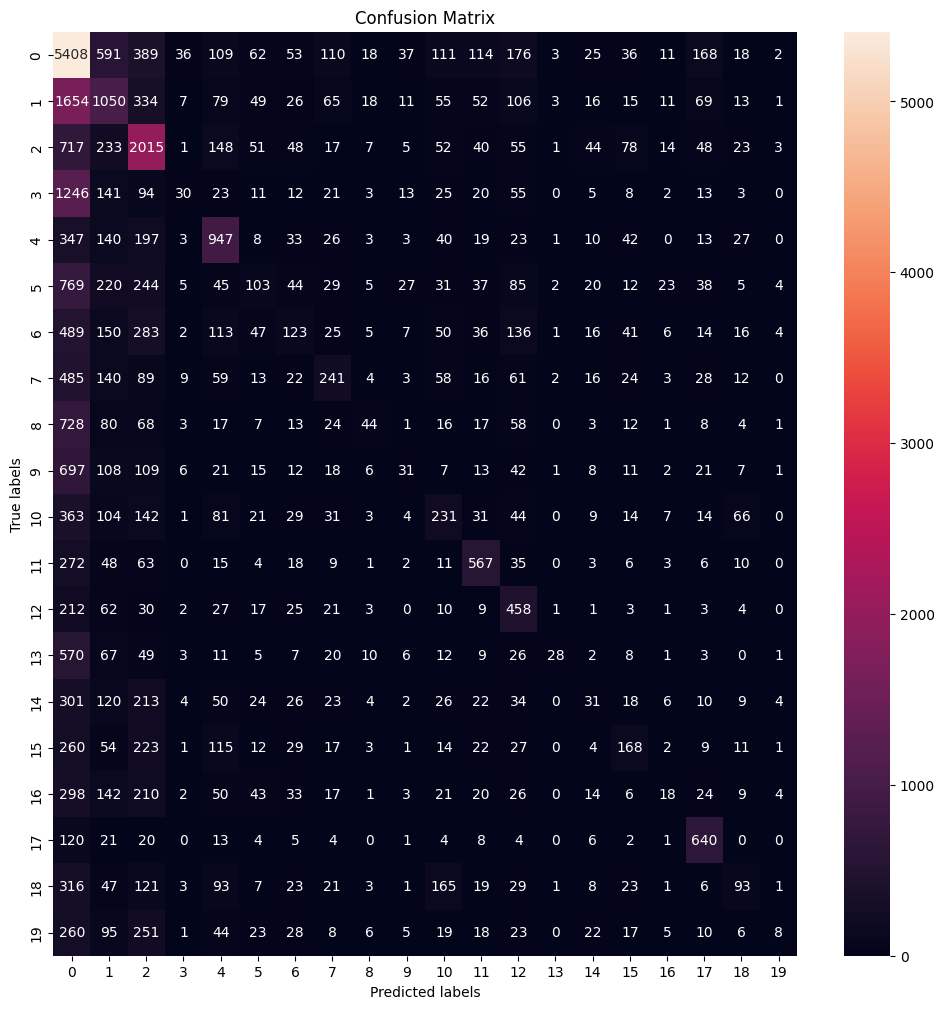

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


cm = confusion_matrix(np.asarray(y_test).argmax(axis=1), np.asarray(classes_x).argmax(axis=1))
# Büyük boyutlu bir figür oluşturun
plt.figure(figsize=(12, 12))

# Isı haritasını çizin
ax = plt.subplot()

sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');